## FH Hagenberg: Automotive Computation
# Project 2: Pedestrian Detection

Welcome to the <b>second Automotive Computing project</b>!<br>
In this project you will implement a solution for detecting pedestrians in a single image!<br>Again the first part of your work is to compute the gradients in the images (you can copy the code of the first project). The next tast is to divide the image into non overlapping cells. For all these cells you have to calculate the orientation histogram. These cells are then parts of overlapping blocks in which all cell histograms are concatinated and normalized (to be robust against illumination).<br>
Finally (which is not the part of your work) you train a linear Support Vector machine and evaluate its performance (you have to write the metric functions).<br>
After you are able to observe the first results, implement the two alternative filters (3x1 and 1x3) for gradient computation which were presented in the lectures.<br>
Which parameters (normalization, block size, cell size) lead to the best results on the test set?

In [1]:
# First check the Python version
# If you have installed a different version, you should install the correct version to avoid conflicts
import sys
if sys.version_info.major != 2 or sys.version_info.minor != 7:
    print('You are running a different version of Python!\n\n' \
          'You should consider using Python 2.7.x.\n')
    print('Try installing the Python 2.7 version of anaconda.\n')

In [35]:
# Now get necessary libraries
try:
    import os # for file management
    import numpy as np # for numeric computations
    import math
    from scipy import ndimage
    
    from scipy.misc import imread, imsave, imresize
    from sklearn import svm
    from skimage import feature # for canny edge computation
    
    from PIL import Image
        
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    # this comment ensures that all images are plotted in this environment and not in a seperate window
    %matplotlib inline
    
except ImportError:
    print('You are missing some packages! ' \
          'Please check your Anaconda installation!')

All the steps before are not relevant for solving the pedestrian detection task. The first step here is to load a single image containing a pedestrian.<br>

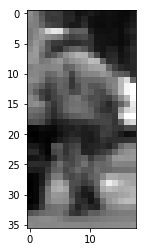

In [36]:
# load a single image
img = Image.open('../../project_2_train/train/1/pos/img_00000.pgm')

numpyImage = None
if img is not None:
    numpyImage = np.array(img)
    plt.imshow(numpyImage, cmap='gray')

Now that we have plotted a single pedestrian we will implement all required steps which are necessary for a HOG descriptor:
1. Compute the gradient images
2. Subdivide the image into non overlapping cells
3. Compute the gradient orientation histogram for each cell
4. Put together a few cells to a block
    a. Compute the normalized histogram for each block
5. Concatenate the block histograms to a large vector (Hog descriptor)

As in the last project, the functions are implemented and tested incremenally. The last step is to use this vector for classification.

# 1. Compute the gradient images.
Please refer to the gradient computation section of project 1.

In [129]:
def correlate3x3(kernel, image):
    """
    This function correlates a filter kernel (3x3) with an image
    
    Parameters
    ----------
    kernel : 2d numpy array
        This is the filter kernel used for the correlation
        
    image : 2d numpy array
        Image which should be correlated with a given kernel
        
    Returns
    -------
    filteredImage : 2d numpy array
        Image after the kernel was applied
    """
    #init = np.zeros(image.shape)
    #for i in xrange(0,len(image),3):
    #    for j in xrange(0,len(image[0]),3):
    #        chunk = image[i:i+3,j:j+3] 
    filteredImage = np.zeros(image.shape)
    row,columns  = image.shape
    for y in range(1, row -1): # height
        for x in range(1, columns -1): # width
            for kx in (0, len(kernel[0])-1): # height 
                for ky in (0, len(kernel[1])-1): # width
                    filteredImage[y,x] +=  kernel[ky,kx] * image[y-1+ky, x-1+kx]
    return filteredImage


In [130]:
def gradientX(image):
    """
    Function computing the edges in X in an given image.
    The parameter image is a 2d numpy array.
    The function returns the edge-x image.
    
    Parameters
    ----------
    image : 2d numpy array
        Input image
        
    Returns
    -------
    gx : 2d numpy array
        Extracted horizontal edges
    """
    kernel = (1.0/8.0) * np.array([[-1, 0, 1], [-2, 0, 2] , [-1, 0, 1]])
    return correlate3x3(kernel, image)

In [131]:
def gradientY(image):
    """
    Function computing the edges in Y in an given image.
    The parameter image is a 2d numpy array.
    The function returns the edge-y image.
    Parameters
    ----------
    image : 2d numpy array
        Input image
        
    Returns
    -------
    gy : 2d numpy array
        Extracted vertical edges
    """
    kernel = (1.0/8.0) *  np.matrix([[1, 2, 1], [0, 0, 0] , [-1, -2, -1]])
    return correlate3x3(kernel, image)

In [132]:
def getMagnitude(gx, gy):
    """
    Function computes the magnitude of the gradient
    
    Parameters
    ----------
    gx : 2d numpy array
        Extracted horizontal edges
        
    gx : 2d numpy array
        Extracted vertical edges
        
    Returns
    -------
    magnitudeImage : 2d numpy array
        Computed magnitudes
    """
    magnitudeImage = np.sqrt(np.power(gy, 2) + np.power(gx, 2))
    return magnitudeImage

In [133]:
def getGradientOrientations(gx,gy):
    """
    This function computes the gradient orientation "image".
    The values are either in radians or in degrees - you have to be aware of it
    
    Parameters
    ----------
    gx : 2d numpy array
        "Image" containing the horizontal edges
    
    gy : 2d numpy array
        "Image" containing the vertical edges

    Returns
    -------
    orientations : 2d numpy array
        The gradient orientations for each pixel stored in an "image".
        Angles in radians, in the range [-pi, pi].
    """
    
    orientations = np.arctan(gx, gy)
    return orientations

In [154]:
gx = gradientX(numpyImage)
gy = gradientY(numpyImage)
magnitudes = getMagnitude(gx,gy)
directions = getGradientOrientations(gx,gy)

# 2. Subdivide the image into non overlapping cells

Your task is now to subdivide the given image into non overlapping cells. Lets define the size of each cell to be 6x6 pixels

In [125]:
# this function converts a list of lists into a single list
flatten = lambda l: [item for sublist in l for item in sublist]

In [142]:
def plotCells(cells, image):
    """
    This function plots the transformed parameters in the image
    
    Parameters
    ----------
    parameters : list of tuples
        The parameters computed by the function houghTransform(...)
        
    image : 2d numpy array
        Image which is populated with lines    
    """
    plt.imshow(image, cmap='gray')
    rows, cols = image.shape
    
    for cell in cells:
        [startColumn, startRow, endColumn, endRow] = cell.getCoordinates()
        endRow += 1
        endColumn += 1
        
        #left top -> right top
        plt.plot([startColumn, endColumn], [startRow, startRow], color='r', linestyle='-', linewidth=1)
        #left top -> left bottom
        plt.plot([startColumn, startColumn], [startRow, endRow], color='r', linestyle='-', linewidth=1)        
        # right bottom -> left bottom
        plt.plot([endColumn, startColumn], [endRow, endRow], color='r', linestyle='-', linewidth=1)
        # right bottom -> right top
        plt.plot([endColumn, endColumn], [endRow, startRow], color='r', linestyle='-', linewidth=1)
        
    plt.axis((0, cols, rows, 0))

In [168]:
class Cell:
    """
    A class containing all relevant functions for computing the orientation histogram
    """
    def __init__(self, numberOfBins, useSigned):
        """
        Constructor of the Cell class.
        
        Parameters
        ----------
        numberOfBins : int
            Number of bins for the orientation histogram

        useSigned : boolean
            Use signed (180°) or unsigned (360°) orientations
        """
        #self._gradientOrientationHistogram = np.zeros(numberOfBins)       
        self._gradientOrientationHistogram = [0] * numberOfBins
        
        self._angleImage = None
        self._magnitudeImage = None
        self._numberOfBins = numberOfBins
        
        # if signed: 0 ... 180
        # if unsigned: 0 ... 360
        self._signedGradient = useSigned
        
        self._startColumn = 0
        self._startRow = 0
        self._endColumn = 0
        self._endRow = 0
        
    def setCoordinates(self, startColumn, startRow, endColumn, endRow):
        """
        This function sets the coordinates of the cell relative to the image
        
        Parameters
        ----------
        startColumn : int
            The left most coordinate of the cell

        startRow : int
            The top most coordinate of the cell
            
        endColumn : int
            The right most coordinate of the cell

        endRow : int
            The bottom most coordinate of the cell
        """
        self._startColumn = startColumn
        self._startRow = startRow
        self._endColumn = endColumn
        self._endRow = endRow
        
    def getCoordinates(self):
        """
        This function return the coordinates of the cell relative to the image
        
        Return
        ----------
        List containing the left top corner and the right bottom border
        """
        return [(self._startColumn,self._startRow),(self._endColumn,self._endRow)]
        

    def setDataRestrictedByInternalCoordinates(self, angles, magnitudes):
        """
        This function sets the internal data (angles and magnitudes).
        Since the variables angles and magnitudes have the size of the full patch (not the size of the cell)
        you have to extract the corresponding submatrix (defined by startColumn, startRow, endColumn, endRow)
        
        Parameters
        ----------
        angles : 2d numpy array
            Orientation of gradients

        magnitudes : 2d numpy array
            Gradient magnitudes
        """
        self._angleImage = angles[startRow:endRow, startColumn:endColumn]
        self._magnitudeImage = magnitudes[startRow:endRow, startColumn:endColumn]
       
                
    def createHistogram(self):
        """
        This function populates the gradient histogram of this cell.
        """
        pass
    
        
    
    def getHistogram(self):
        """
        This function returns the cell histogram
        
        Return
        ----------
        numpy array containing the cell's gradient orientation histogram.
        """
        return createHistogram()
  
    
    def plotHistogram(self):
        """
        This function plots the cell's gradient orientation histogram.
        """
        bins = range(self._numberOfBins)
        plt.bar(bins,self._gradientOrientationHistogram)
        plt.title("Gradient Orientation Histogram of a cell")
        plt.ylabel("Magnitude vote")
        plt.xlabel("Bin")
        plt.show()

In [179]:
cellWidth = 6
cellHeight = 6

# we define 9 bins for the gradient orientation histogram
numberOfBins = 9 # <- EXPERIMENT
useSigned = False # <- EXPERIMENT

In [206]:
def subdivideIntoCells(image, cellHeight, cellWidth, numberOfBins, useSigned):
    """
    This function divides the image into tiles.

    Parameters
    ----------
    image : 2d numpy array
        The pedestrian or background imge

    cellHeight : int
        The height of a cell
        
    cellWidth : int
        The width of a cell
    
    numberOfBins : int
        The number of bins used for the gradient orientation histogram
        
    useSigned : boolean
        If true we use 180 degrees else 360 degrees
        
    Return
    ---------
    cellGrid - 2d grid of cells
    """
    cell = Cell(numberOfBins, useSigned)
    numRows , numColumns = image.shape
    
    numCellsHorizontal = int(math.ceil(numColumns / cellWidth)) 
    numCellsVertical = int(math.ceil(numRows / cellHeight)) 
        
    
    
    # determine the number of cells used for the image        
    assert( (0 == (numRows % cellHeight)) and (0 == (numColumns % cellWidth)))
    

    # create a 2d grid of cells
    cellGrid = [[Cell(numberOfBins, useSigned) for j in range(numCellsHorizontal)] for i in range(numCellsVertical)]

    
    for x in range(len(cellGrid)): # height 
        for y in range(len(cellGrid[0])): # width
            startRow = cellHeight * y
            startColumn = cellWidth * x
            endColumn =  cellWidth *(x+1) -1
            endRow = cellHeight * (y+1) -1
            cellGrid[x][y].setCoordinates(startColumn, startRow,  endColumn, endRow) #startColumn, startRow, endColumn, endRow
            #print cellGrid[x][y].getCoordinates()

3 6
[(0, 0), (5, 5)]
[(0, 6), (5, 11)]
[(0, 12), (5, 17)]
[(6, 0), (11, 5)]
[(6, 6), (11, 11)]
[(6, 12), (11, 17)]
[(12, 0), (17, 5)]
[(12, 6), (17, 11)]
[(12, 12), (17, 17)]
[(18, 0), (23, 5)]
[(18, 6), (23, 11)]
[(18, 12), (23, 17)]
[(24, 0), (29, 5)]
[(24, 6), (29, 11)]
[(24, 12), (29, 17)]
[(30, 0), (35, 5)]
[(30, 6), (35, 11)]
[(30, 12), (35, 17)]
None


In [207]:
cellGrid = subdivideIntoCells(numpyImage, cellHeight, cellWidth, numberOfBins, useSigned)
plotCells(flatten(cellGrid), numpyImage)

3 6
[(0, 0), (5, 5)]
[(0, 6), (5, 11)]
[(0, 12), (5, 17)]
[(6, 0), (11, 5)]
[(6, 6), (11, 11)]
[(6, 12), (11, 17)]
[(12, 0), (17, 5)]
[(12, 6), (17, 11)]
[(12, 12), (17, 17)]
[(18, 0), (23, 5)]
[(18, 6), (23, 11)]
[(18, 12), (23, 17)]
[(24, 0), (29, 5)]
[(24, 6), (29, 11)]
[(24, 12), (29, 17)]
[(30, 0), (35, 5)]
[(30, 6), (35, 11)]
[(30, 12), (35, 17)]


TypeError: 'NoneType' object is not iterable

## Test the histogram generation

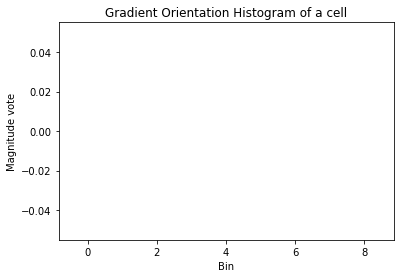

In [141]:
test_magnitudes = np.ones((6,6))
test_orientations = np.ones((6,6)) * 90.0 # only 90 degree angles
test_orientations = test_orientations * math.pi / 180.0
test_useSigned = True
test_numberOfBins = 9

test_cell = Cell(test_numberOfBins, test_useSigned)
test_cell.setCoordinates(0,0,5,5)
test_cell.setDataRestrictedByInternalCoordinates( test_orientations, test_magnitudes )
test_cell.createHistogram()
test_cell.plotHistogram()

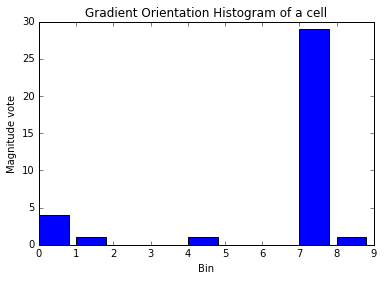

In [303]:
test_magnitudes = np.ones((6,6))
test_orientations = np.ones((6,6)) * 300
test_orientations[0,0] = 180
test_orientations[0,1] = 19
test_orientations[0,2] = 20
test_orientations[0,3] = 39
test_orientations[0,4] = 40
test_orientations[0,5] = 359
test_orientations[1,0] = 360
test_orientations = test_orientations * math.pi / 180.0
test_useSigned = True
test_numberOfBins = 9

test_cell = Cell(test_numberOfBins, test_useSigned)
test_cell.setCoordinates(0,0,5,5)
test_cell.setDataRestrictedByInternalCoordinates( test_orientations, test_magnitudes )
test_cell.createHistogram()
test_histogram = test_cell.plotHistogram()